In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter, LogLocator
import statsmodels.api as sm

# Based on Jäckel (2015)
from py_vollib.black.greeks.analytical import delta, vega

### Import Data

In [ ]:
# Import data with derivativesb fro each approximation and Monte Carlo hedges
with open("mapping and calibration/files/hedged_chunks.pkl", "rb") as f:
    chunks = pickle.load(f)
df = pd.concat(chunks, ignore_index=True)

### Calculate Hedges

In [4]:
# Compute Black delta 
df['dB_dF'] = df.apply(
    lambda row: delta(
        flag='c',  
        F=row['forward_price'],
        K=row['strike_price'],
        t=row['T'],
        r=0.0,  
        sigma=row['iv_base']
    ),
    axis=1
)

# Compute Black vega 
df['dB_dalpha'] = df.apply(
    lambda row: vega(
        flag='c', 
        F=row['forward_price'],
        K=row['strike_price'],
        t=row['T'],
        r=0.0,  
        sigma=row['iv_base']
    ) * 100,
    axis=1
)

# SABR Hedges
for approximator in ["hagan", "antonov", "nn"]:
    df[f"dV_dF_{approximator}"] = df["dB_dalpha"]  * df[f"dIV_dF_{approximator}"] + df["dB_dF"]
    df[f"dV_dalpha_{approximator}"] = df["dB_dalpha"] * df[f"dIV_dalpha_{approximator}"]
    df[f"dV_drho_{approximator}"] = df["dB_dalpha"] * df[f"dIV_drho_{approximator}"]
    df[f"dV_dnu_{approximator}"] = df["dB_dalpha"] * df[f"dIV_dnu_{approximator}"]

/Users/vincentklaer/Documents/Thesis/final code/.venv/lib/python3.9/site-packages/py_vollib/ref_python/black/__init__.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / denominator
/Users/vincentklaer/Documents/Thesis/final code/.venv/lib/python3.9/site-packages/py_vollib/ref_python/black/__init__.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  return numerator / denominator


### Calculating and Visualizing Errors

In [5]:
for approximator in ["hagan", "antonov", "nn"]:
    df[f"delta_rae_{approximator}"] = (df["dV_dF0"] - df[f"dV_dF_{approximator}"]) / df["dV_dF0"] * 100
    df[f"vega_rae_{approximator}"] = (df["dV_dalpha"] - df[f"dV_dalpha_{approximator}"]) / df["dV_dalpha"] * 100
    df[f"vanna_rae_{approximator}"] = (df["dV_drho"] - df[f"dV_drho_{approximator}"]) / df["dV_drho"] * 100
    df[f"volga_rae_{approximator}"] = (df["dV_dnu"] - df[f"dV_dnu_{approximator}"]) / df["dV_dnu"] * 100

    df[f"delta_err_{approximator}"] = (df["dV_dF0"] - df[f"dV_dF_{approximator}"])
    df[f"vega_err_{approximator}"] = (df["dV_dalpha"] - df[f"dV_dalpha_{approximator}"])
    df[f"vanna_err_{approximator}"] = (df["dV_drho"] - df[f"dV_drho_{approximator}"])
    df[f"volga_err_{approximator}"] = (df["dV_dnu"] - df[f"dV_dnu_{approximator}"])

    df[f"delta_abs_{approximator}"] = abs(df["dV_dF0"] - df[f"dV_dF_{approximator}"])
    df[f"vega_abs_{approximator}"] = abs(df["dV_dalpha"] - df[f"dV_dalpha_{approximator}"])
    df[f"vanna_abs_{approximator}"] = abs(df["dV_drho"] - df[f"dV_drho_{approximator}"])
    df[f"volga_abs_{approximator}"] = abs(df["dV_dnu"] - df[f"dV_dnu_{approximator}"])

In [7]:
abs_medians = {}
for approximator in ["hagan", "antonov", "nn"]:
    abs_medians[approximator] = {
        "delta_abs_median": df[f"delta_abs_{approximator}"].median(),
        "vega_abs_median": df[f"vega_abs_{approximator}"].median(),
        "vanna_abs_median": df[f"vanna_abs_{approximator}"].median(),
        "volga_abs_median": df[f"volga_abs_{approximator}"].median()
    }

abs_medians = pd.DataFrame(abs_medians)
abs_medians

,hagan,antonov,nn
delta_abs_median,0.008640,0.009127,0.007331
vega_abs_median,0.019778,0.008114,0.007603
vanna_abs_median,0.000418,0.000516,0.000318
volga_abs_median,0.001361,0.000431,0.000223


### Vega

/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_2562/151541779.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_errors = df.groupby("moneyness_bin")[[


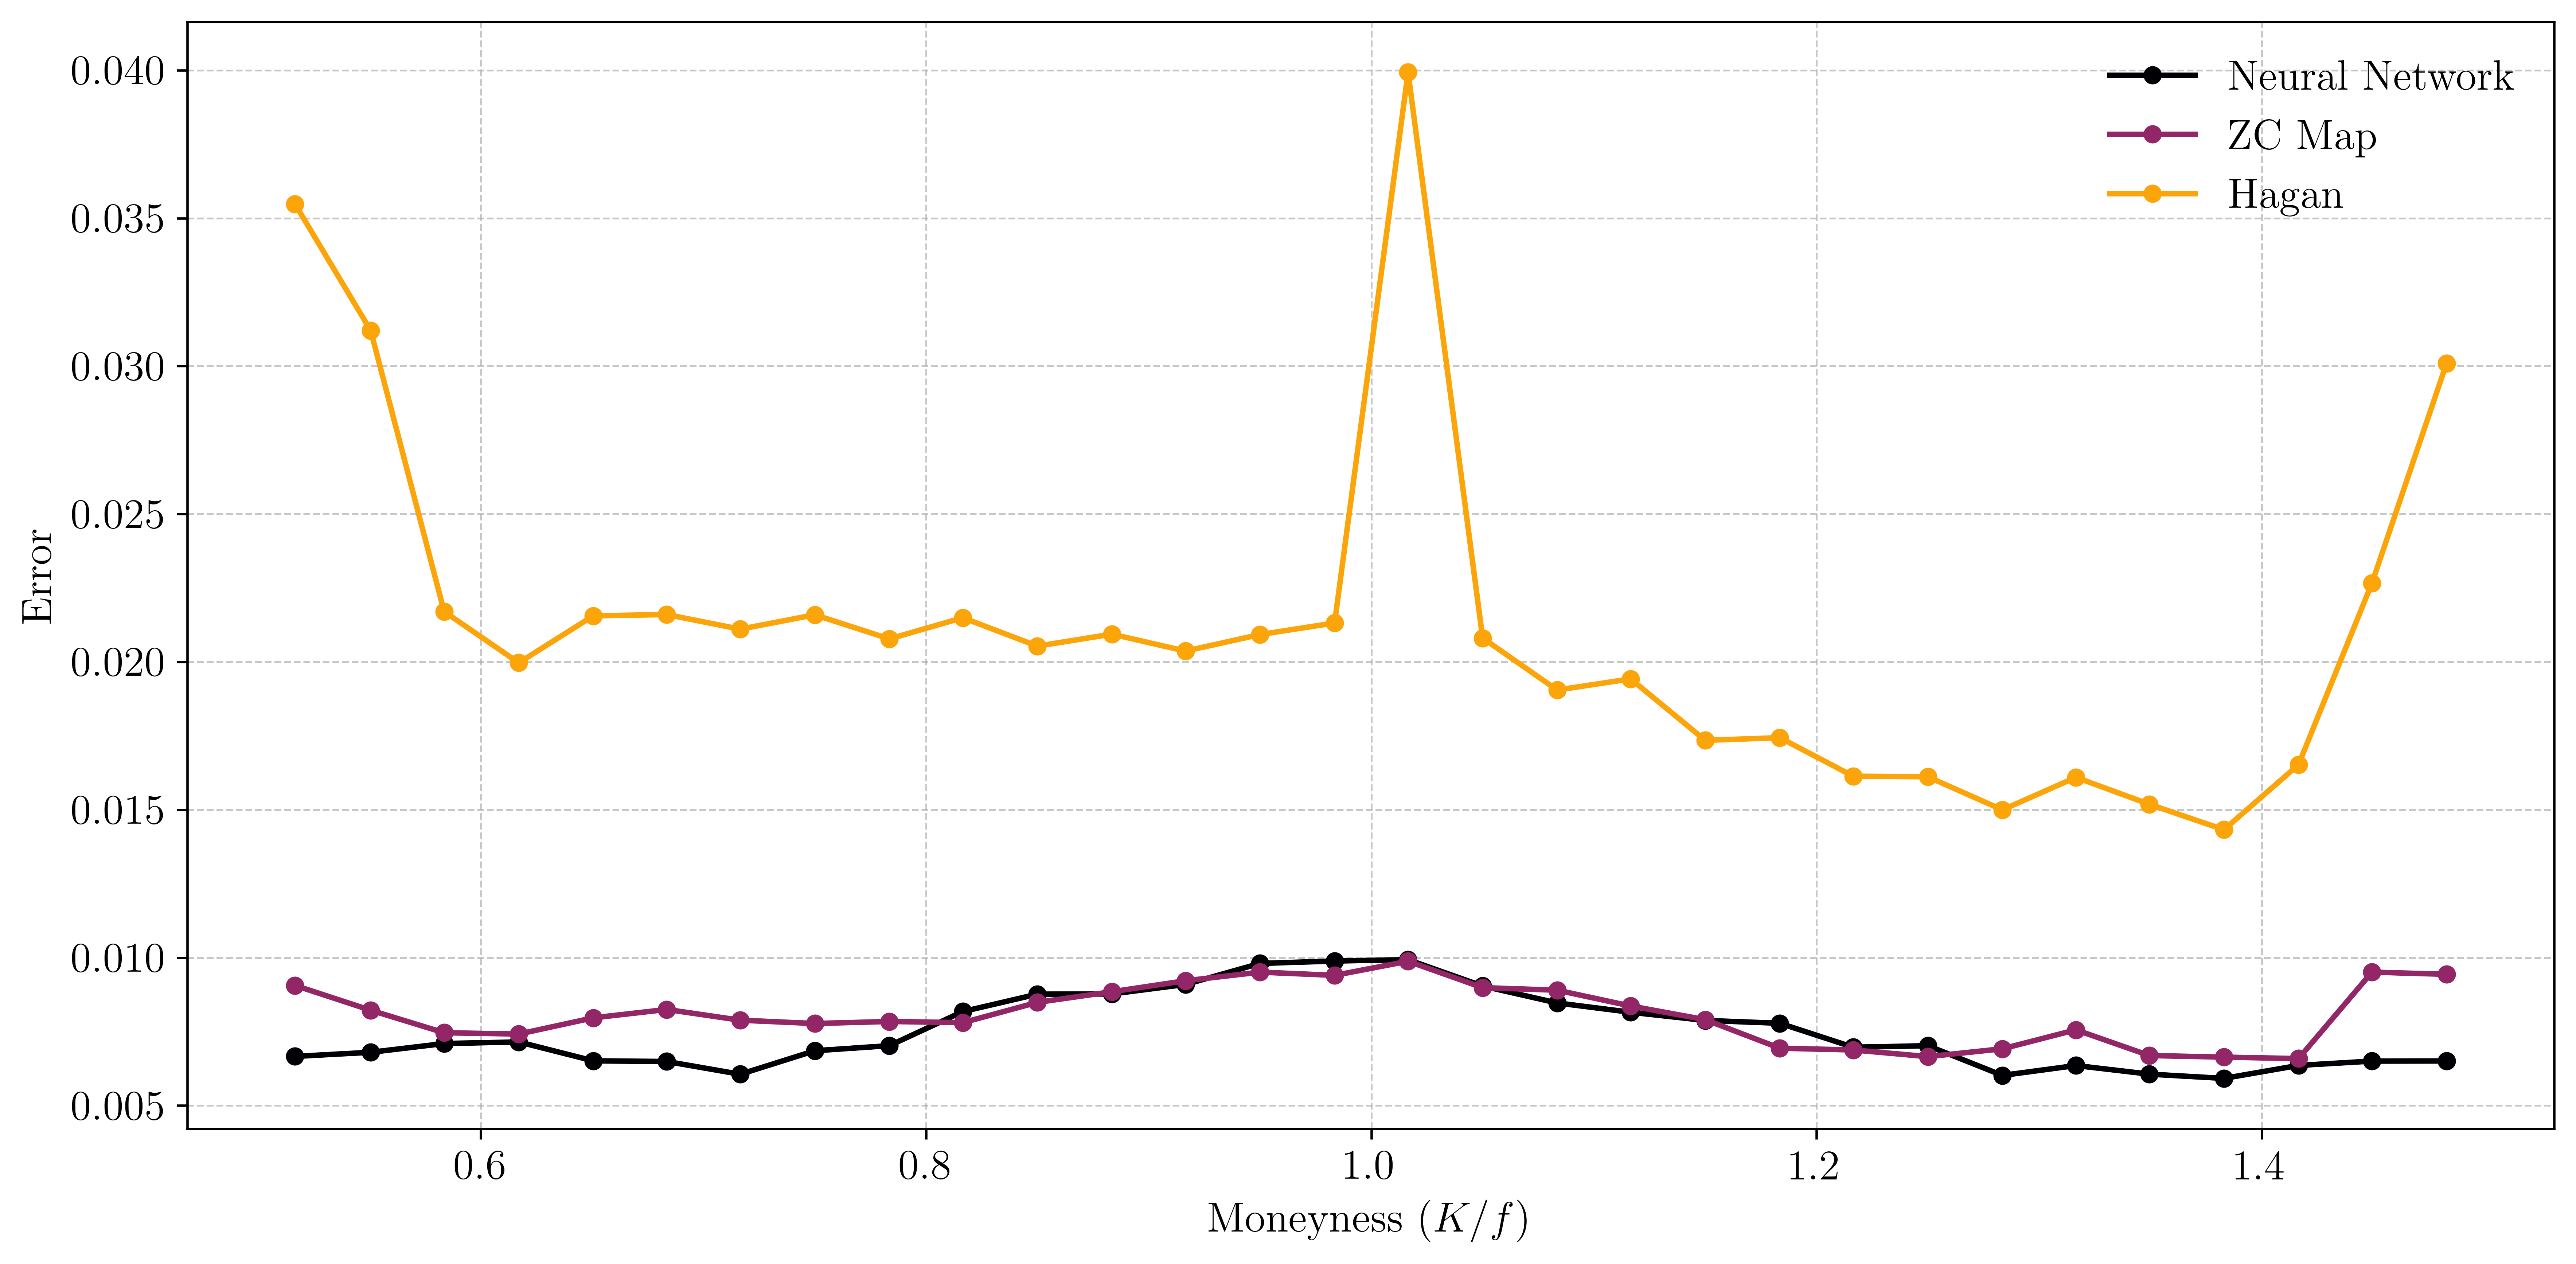

In [ ]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Latin Modern Roman'],
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'text.usetex': True,
})

df["moneyness"] = df["strike_price"] / df["forward_price"]
df["moneyness_bin"] = pd.cut(df["moneyness"], bins=30)

median_errors = df.groupby("moneyness_bin")[[
    f"vega_abs_nn", f"vega_abs_antonov", f"vega_abs_hagan"
]].median()

bin_centers = [interval.mid for interval in median_errors.index]

base_cmap = plt.cm.inferno
truncated_cmap = base_cmap(np.linspace(0, 0.8, 3))

plt.figure(figsize=(12, 6), dpi=600)

plt.plot(bin_centers, median_errors[f"vega_abs_nn"],
         label=r'Neural Network',
         color=truncated_cmap[0],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.plot(bin_centers, median_errors[f"vega_abs_antonov"],
         label=r'ZC Map',
         color=truncated_cmap[1],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.plot(bin_centers, median_errors[f"vega_abs_hagan"],
         label=r'Hagan',
         color=truncated_cmap[2],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.xlabel(r'Moneyness ($K/f$)')
plt.ylabel(r'Error')

plt.legend(frameon=False)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()

### Delta

/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_88426/2963098498.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_errors = df.groupby("moneyness_bin")[[


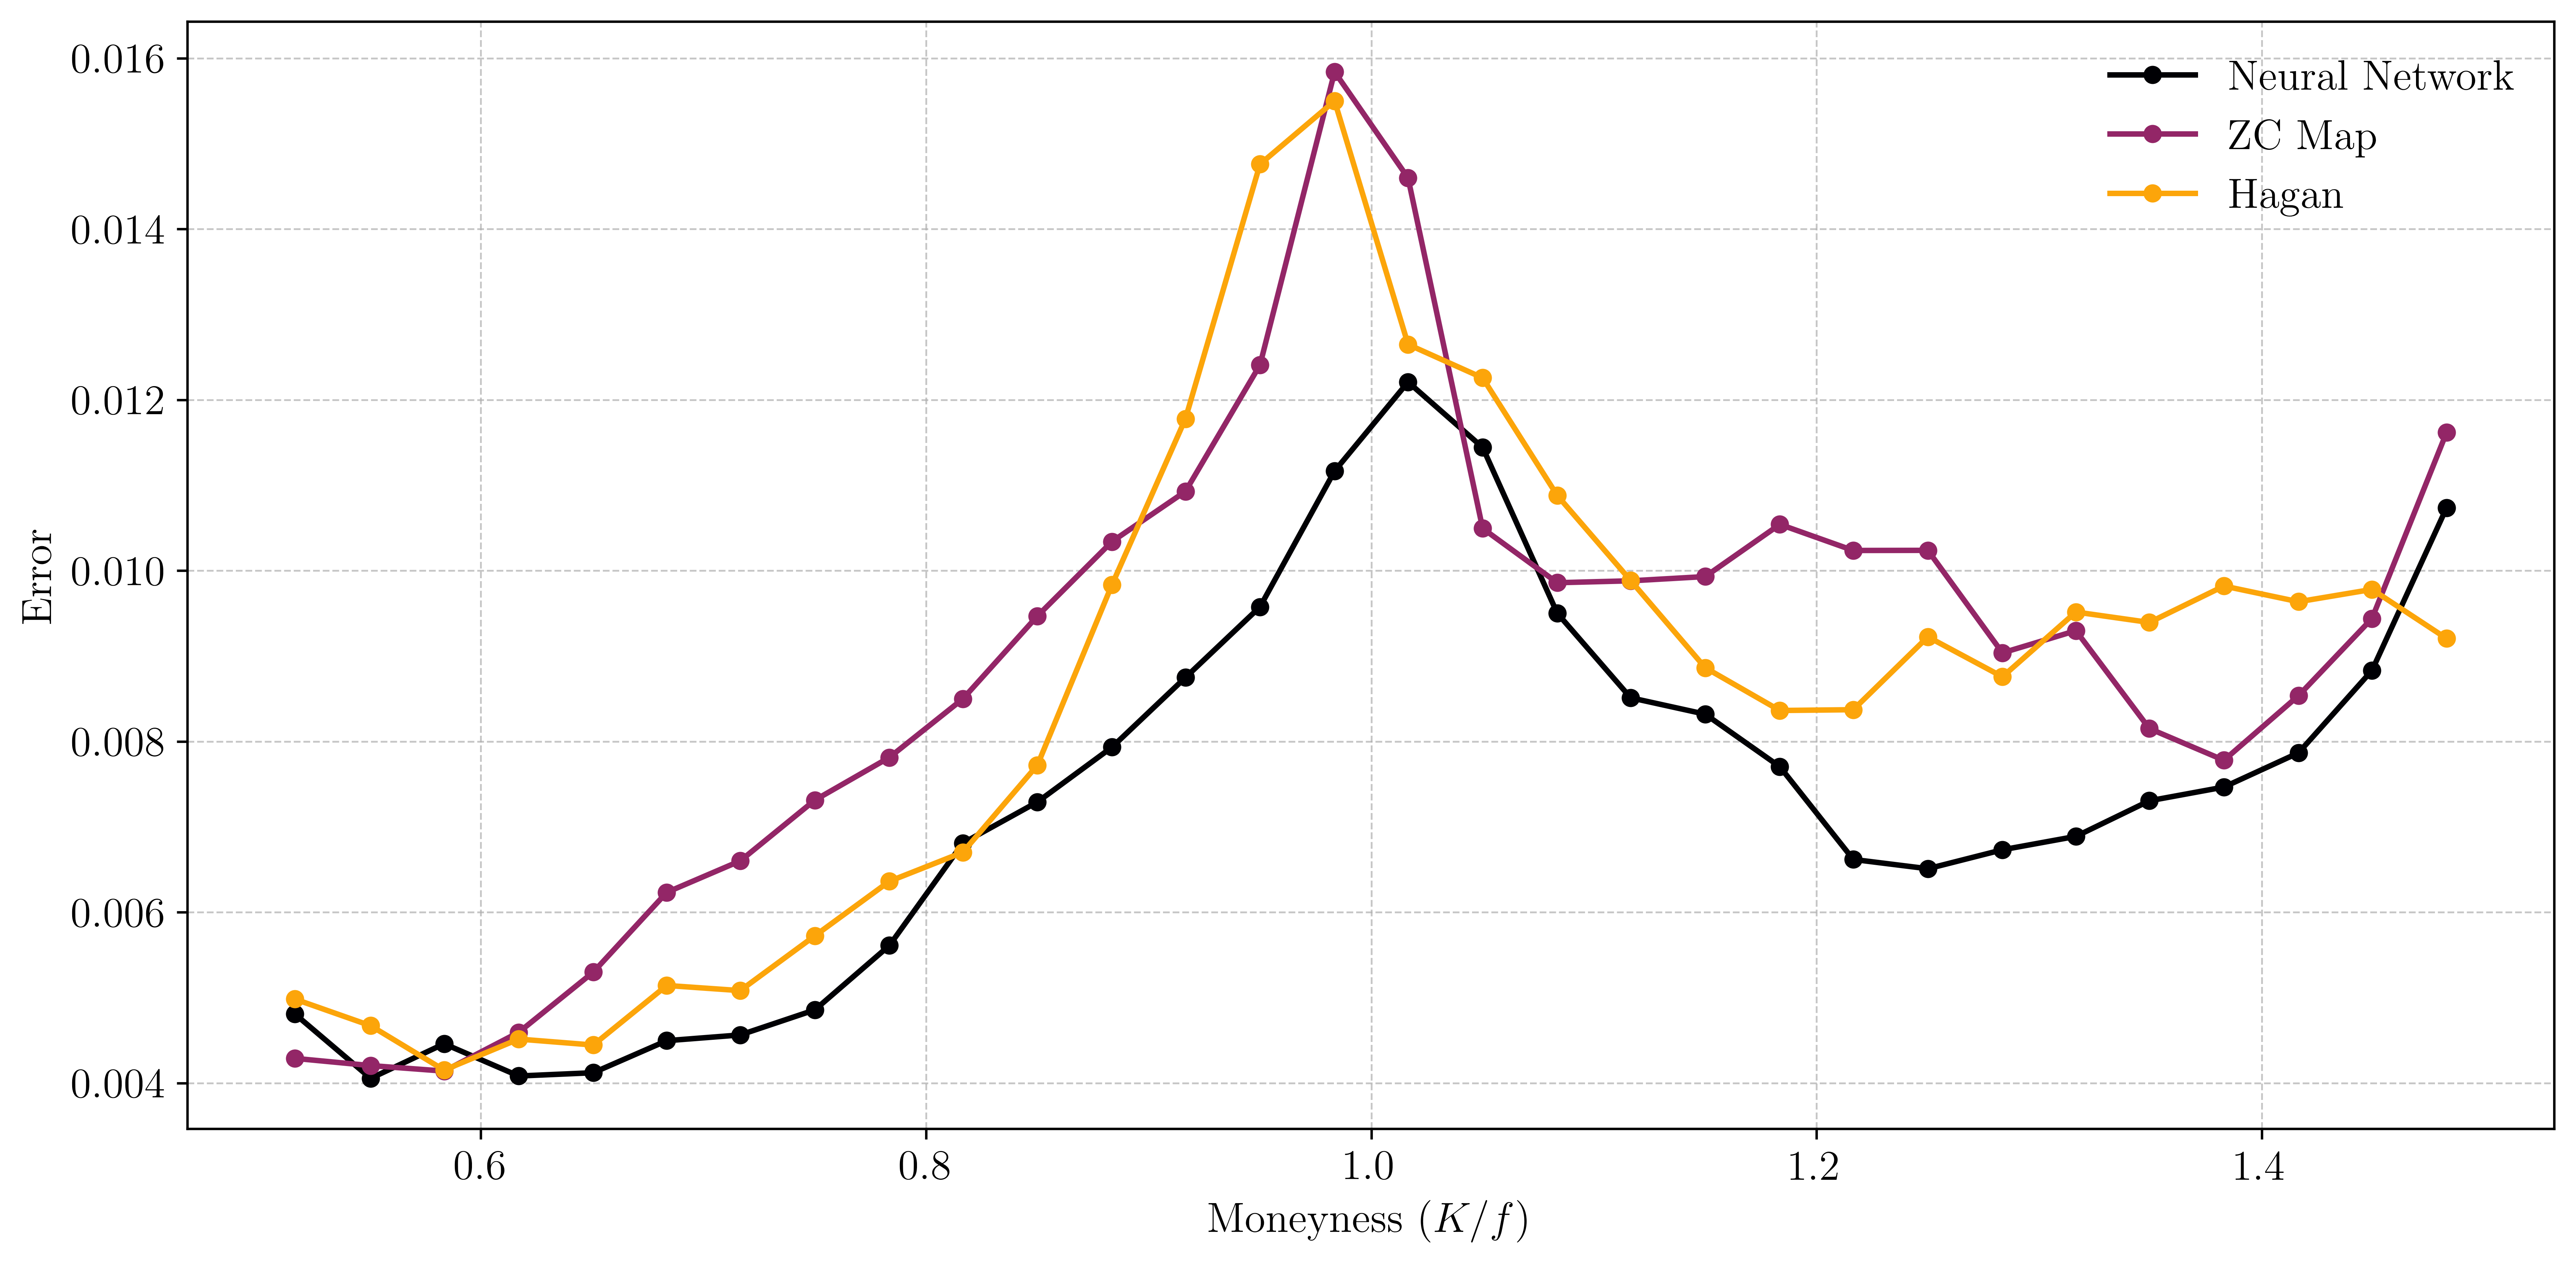

In [ ]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Latin Modern Roman'],
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'text.usetex': True,
})

df["moneyness"] = df["strike_price"] / df["forward_price"]
df["moneyness_bin"] = pd.cut(df["moneyness"], bins=30)

median_errors = df.groupby("moneyness_bin")[[
    f"delta_abs_nn", f"delta_abs_antonov", f"delta_abs_hagan"
]].median()

bin_centers = [interval.mid for interval in median_errors.index]

base_cmap = plt.cm.inferno
truncated_cmap = base_cmap(np.linspace(0, 0.8, 3))

plt.figure(figsize=(12, 6), dpi=600)

plt.plot(bin_centers, median_errors[f"delta_abs_nn"],
         label=r'Neural Network',
         color=truncated_cmap[0],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.plot(bin_centers, median_errors[f"delta_abs_antonov"],
         label=r'ZC Map',
         color=truncated_cmap[1],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.plot(bin_centers, median_errors[f"delta_abs_hagan"],
         label=r'Hagan',
         color=truncated_cmap[2],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.xlabel(r'Moneyness ($K/f$)')
plt.ylabel(r'Error')

plt.legend(frameon=False)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()

### Vanna

/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_88426/3048686776.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_errors = df.groupby("moneyness_bin")[[


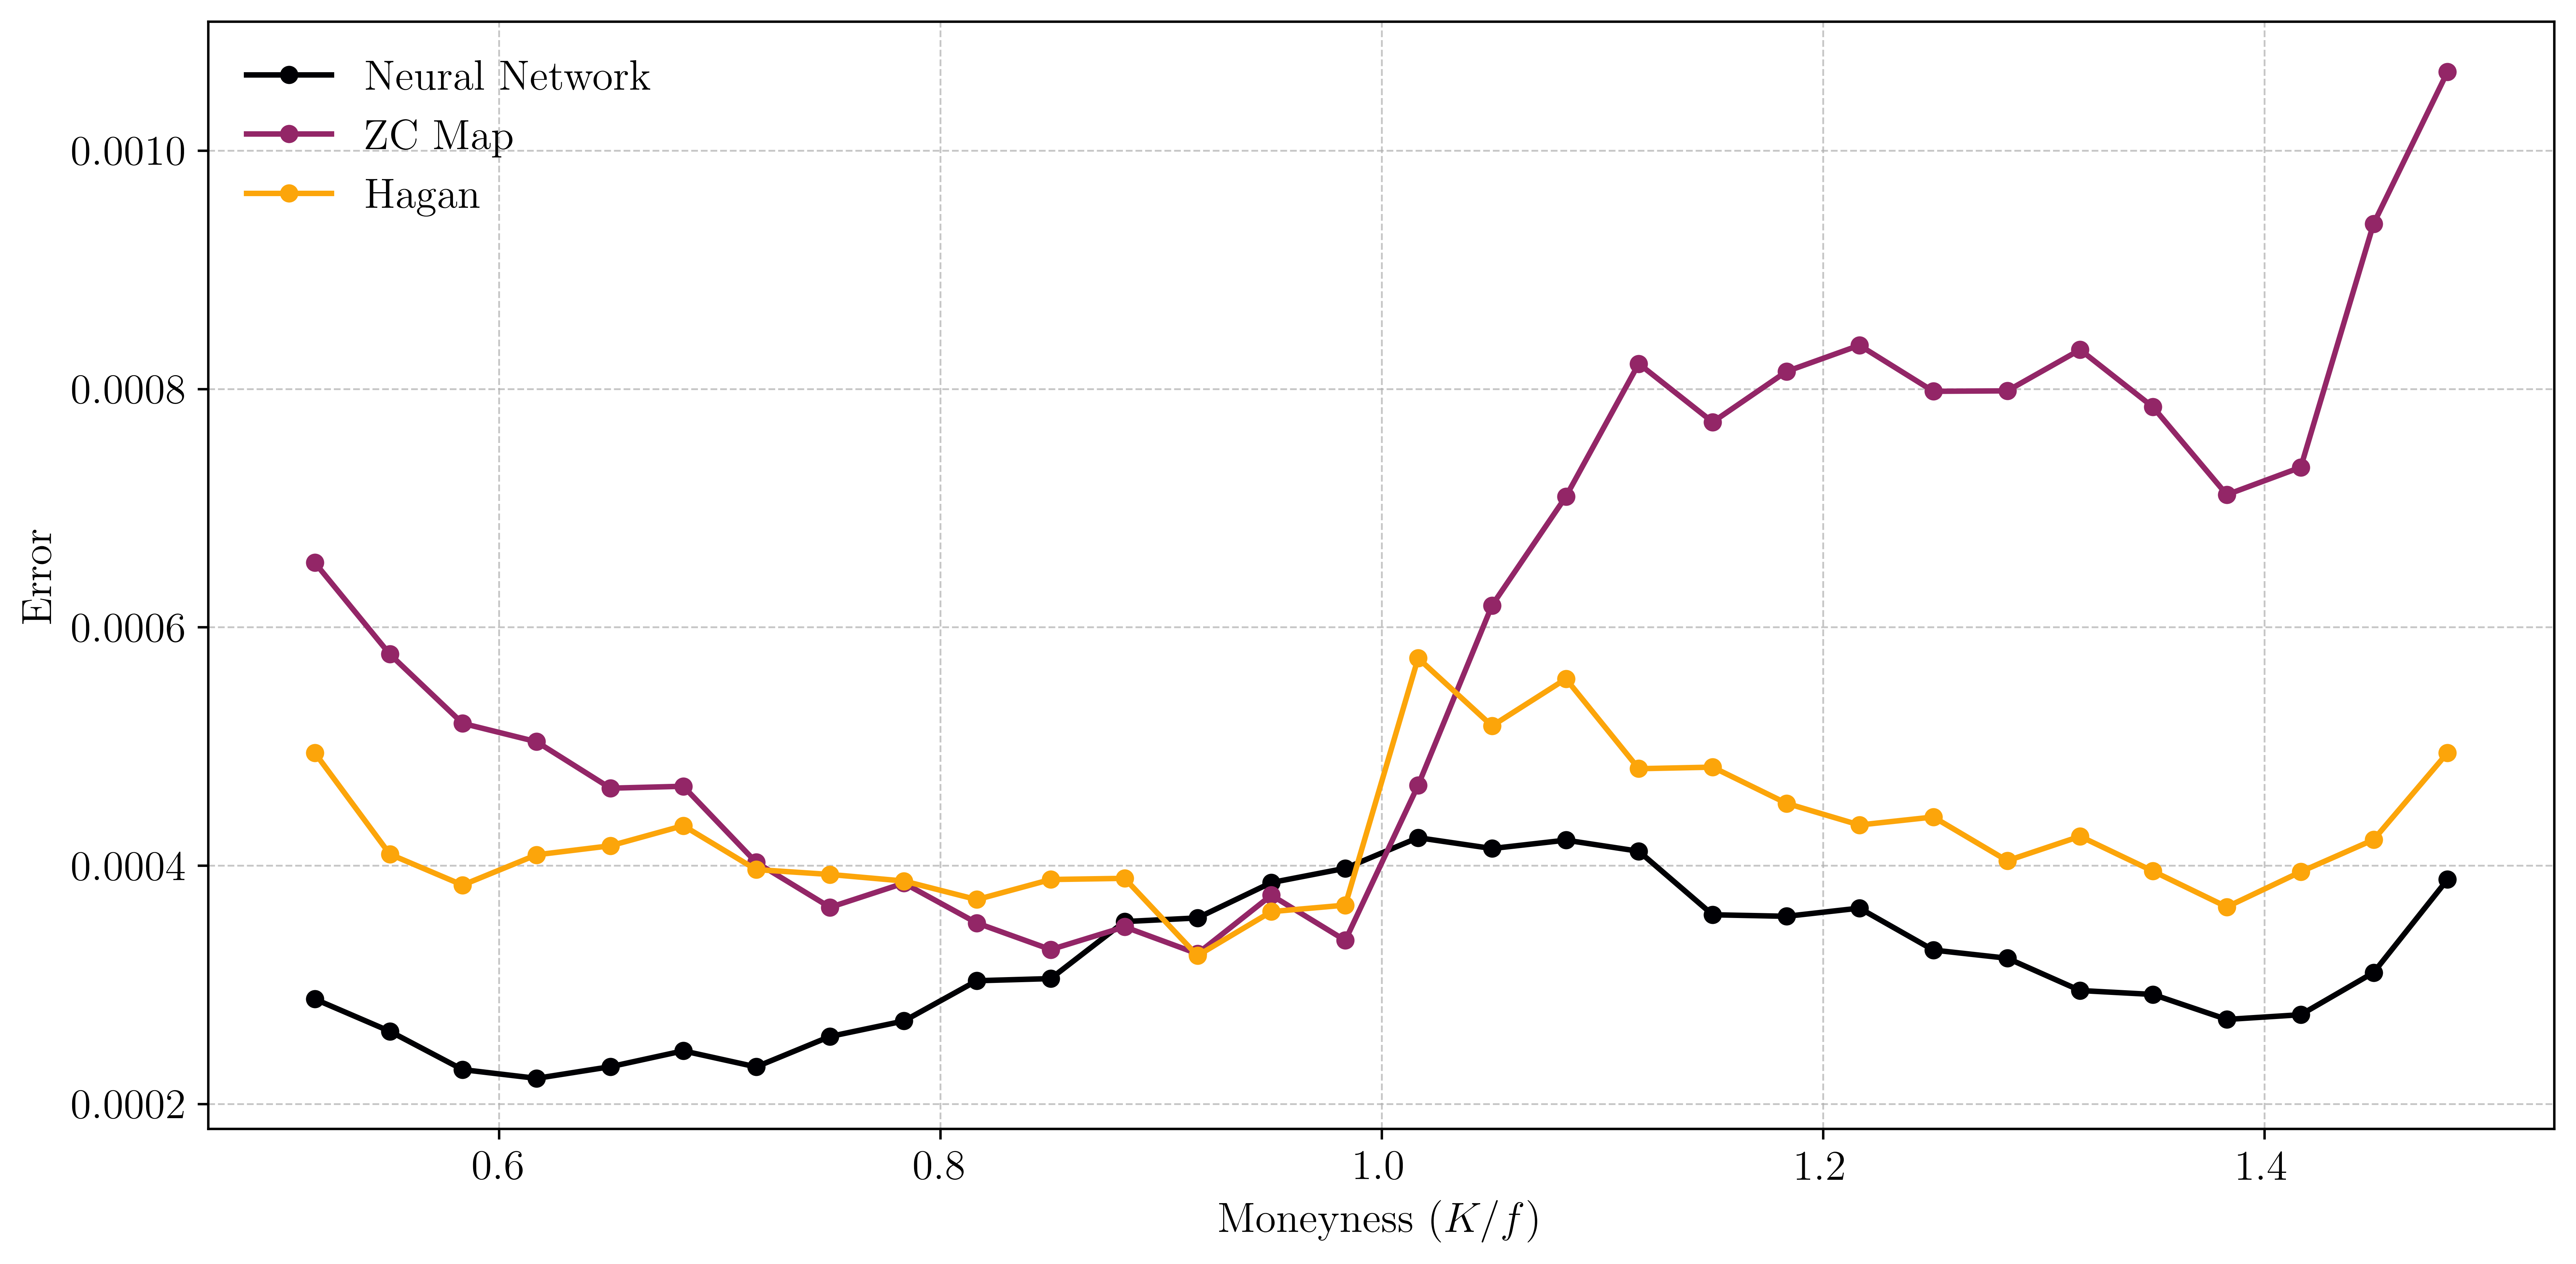

In [ ]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Latin Modern Roman'],
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'text.usetex': True,
})

df["moneyness"] = df["strike_price"] / df["forward_price"]
df["moneyness_bin"] = pd.cut(df["moneyness"], bins=30)

median_errors = df.groupby("moneyness_bin")[[
    f"vanna_abs_nn", f"vanna_abs_antonov", f"vanna_abs_hagan"
]].median()

bin_centers = [interval.mid for interval in median_errors.index]

base_cmap = plt.cm.inferno
truncated_cmap = base_cmap(np.linspace(0, 0.8, 3))

plt.figure(figsize=(12, 6), dpi=600)

plt.plot(bin_centers, median_errors[f"vanna_abs_nn"],
         label=r'Neural Network',
         color=truncated_cmap[0],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.plot(bin_centers, median_errors[f"vanna_abs_antonov"],
         label=r'ZC Map',
         color=truncated_cmap[1],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.plot(bin_centers, median_errors[f"vanna_abs_hagan"],
         label=r'Hagan',
         color=truncated_cmap[2],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.xlabel(r'Moneyness ($K/f$)')
plt.ylabel(r'Error')

plt.legend(frameon=False)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()

### Volga

/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_2562/3838644578.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_errors = df.groupby("moneyness_bin")[[


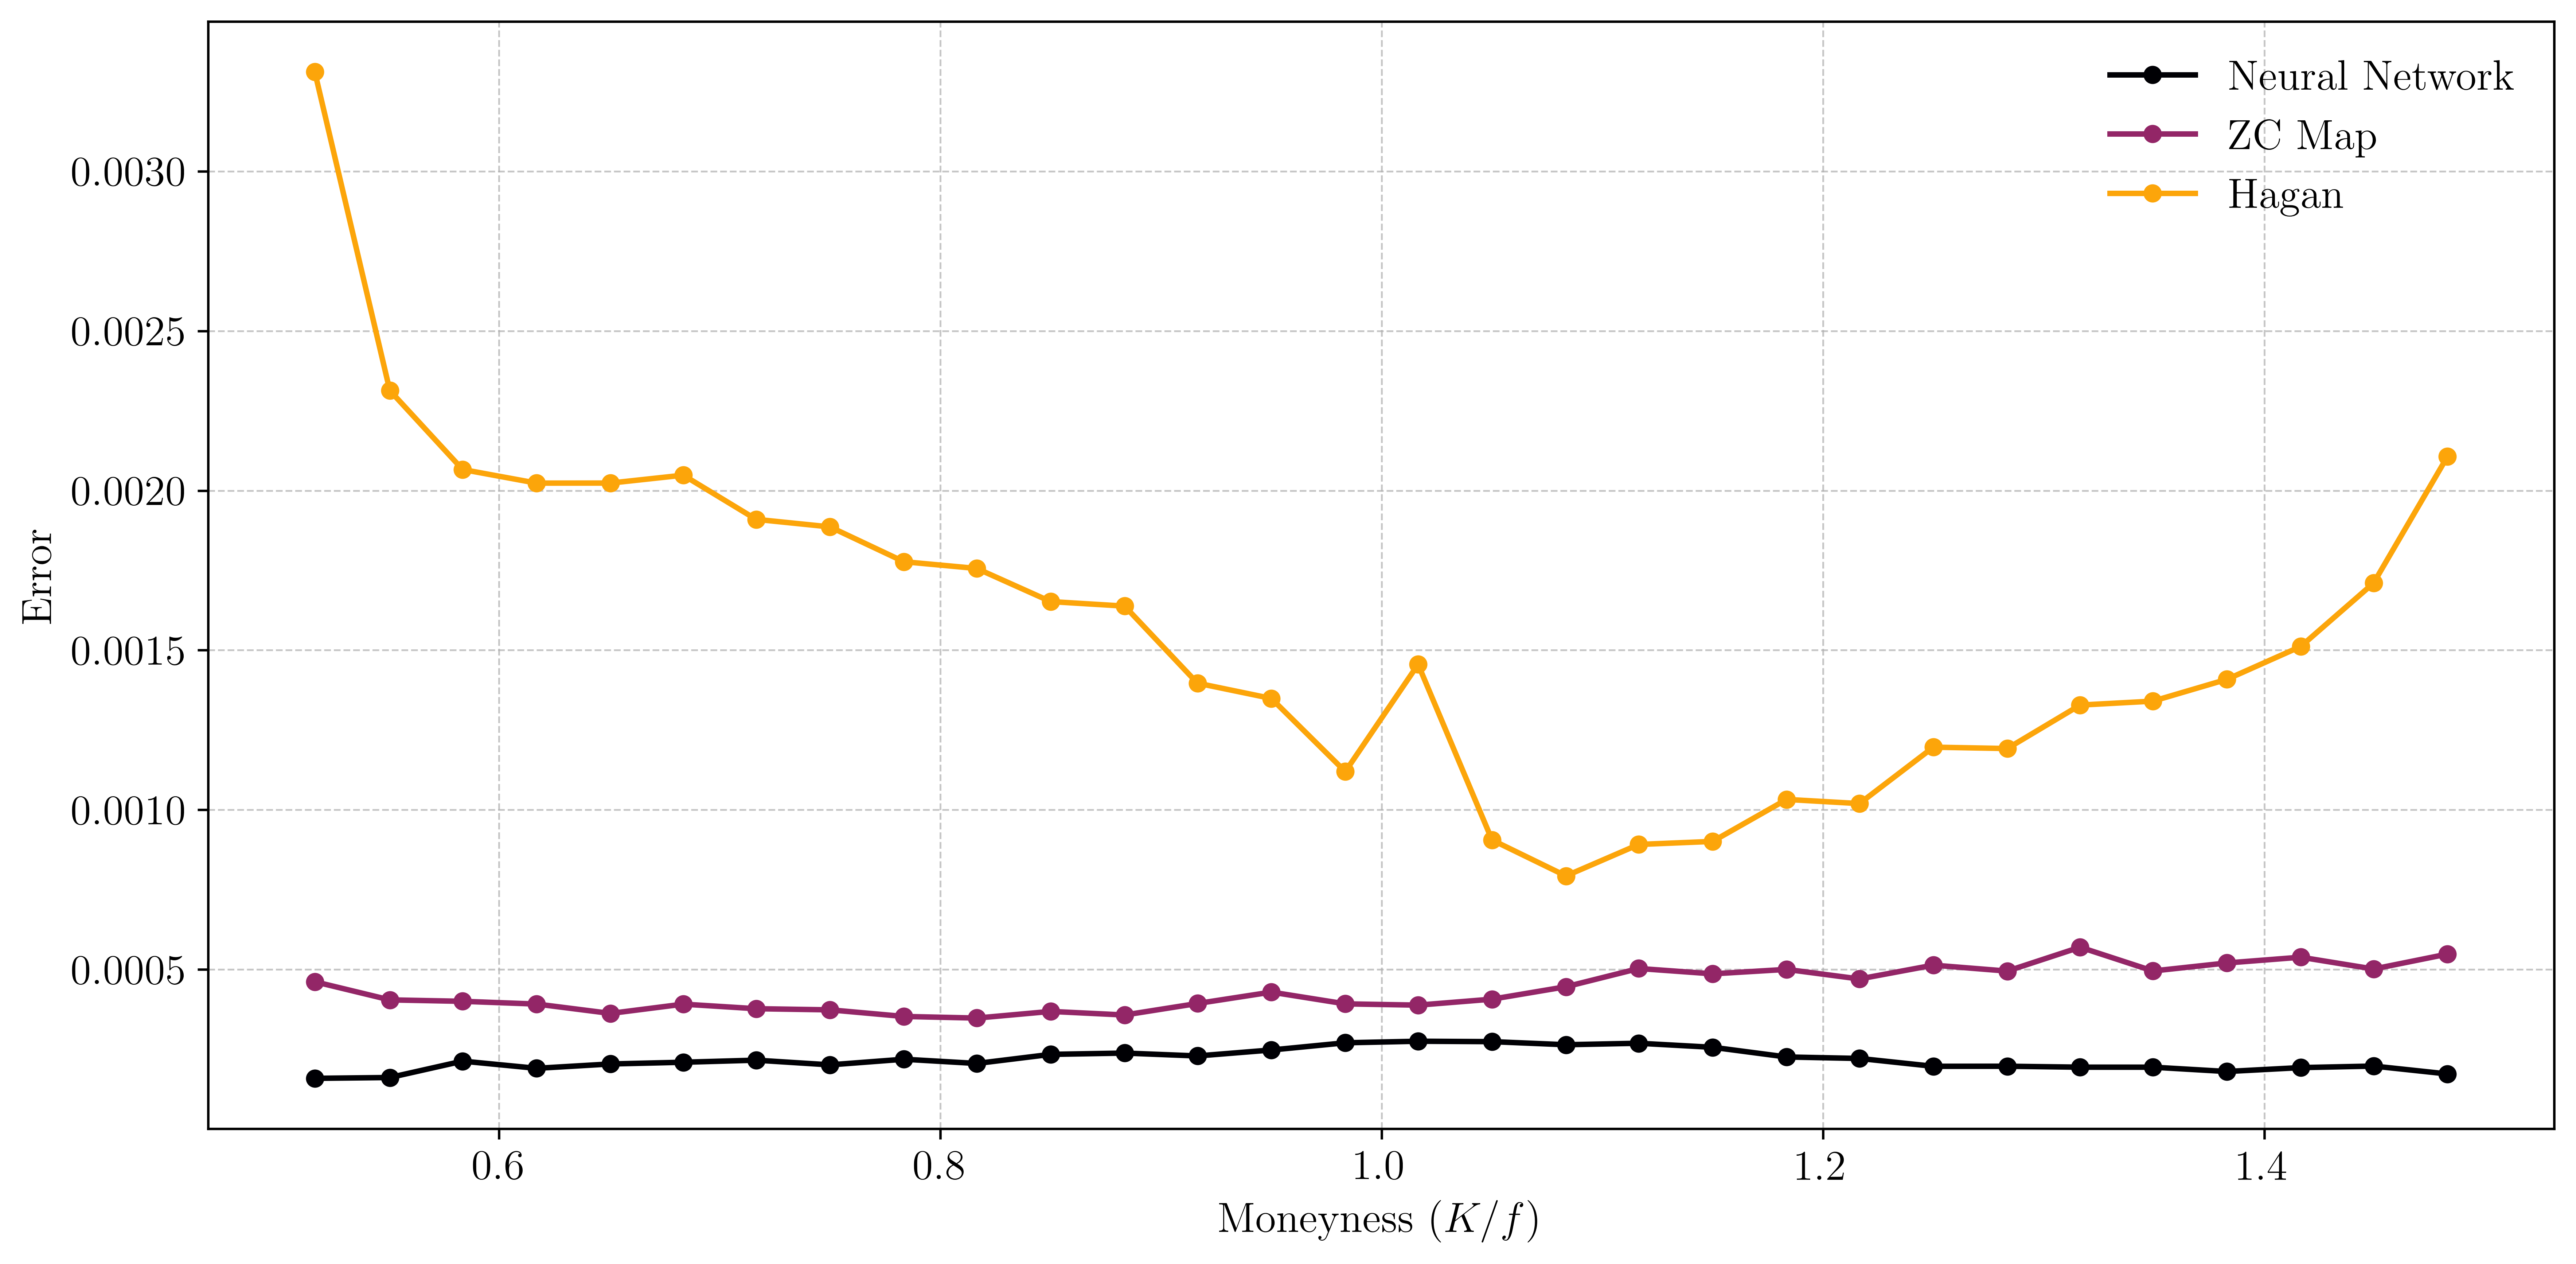

In [ ]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Latin Modern Roman'],
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'text.usetex': True,
})

df["moneyness"] = df["strike_price"] / df["forward_price"]
df["moneyness_bin"] = pd.cut(df["moneyness"], bins=30)

median_errors = df.groupby("moneyness_bin")[[
    f"volga_abs_nn", f"volga_abs_antonov", f"volga_abs_hagan"
]].median()

bin_centers = [interval.mid for interval in median_errors.index]

base_cmap = plt.cm.inferno
truncated_cmap = base_cmap(np.linspace(0, 0.8, 3))

plt.figure(figsize=(12, 6), dpi=600)

plt.plot(bin_centers, median_errors[f"volga_abs_nn"],
         label=r'Neural Network',
         color=truncated_cmap[0],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.plot(bin_centers, median_errors[f"volga_abs_antonov"],
         label=r'ZC Map',
         color=truncated_cmap[1],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.plot(bin_centers, median_errors[f"volga_abs_hagan"],
         label=r'Hagan',
         color=truncated_cmap[2],
         marker='o', linestyle='-', linewidth=1.8, markersize=5)

plt.xlabel(r'Moneyness ($K/f$)')
plt.ylabel(r'Error')

plt.legend(frameon=False)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()